# Adult Income Prediction Project
This project aims to predict whether an individual's income exceeds $50K/yr based on census data.

**Sections:**
1. Introduction
2. Dataset Description & EDA
3. Data Preprocessing
4. Data Splitting
5. Model Training & Evaluation (KNN, Decision Tree, Logistic Regression, Naive Bayes, Neural Network)
6. Unsupervised Learning (KMeans Clustering)
7. Model Comparison
8. Conclusion

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

## 1. Load Dataset
We will use the provided CSV file (`adult income dataset.csv`). You can switch to TXT or JSON as needed.

In [3]:
# Load the dataset
df = pd.read_csv('adult income dataset.csv')
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (48842, 15)


,Age,Workclass,Final Weight,Education,Education Number of Years,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 2. Dataset Description & Exploratory Data Analysis (EDA)
- Overview of features, missing values, and class distribution.
- Correlation analysis and visualization.

Missing values per column:
Age                          0
Workclass                    0
Final Weight                 0
Education                    0
Education Number of Years    0
Marital-status               0
Occupation                   0
Relationship                 0
Race                         0
Sex                          0
Capital-gain                 0
Capital-loss                 0
Hours-per-week               0
Native-country               0
target                       0
dtype: int64


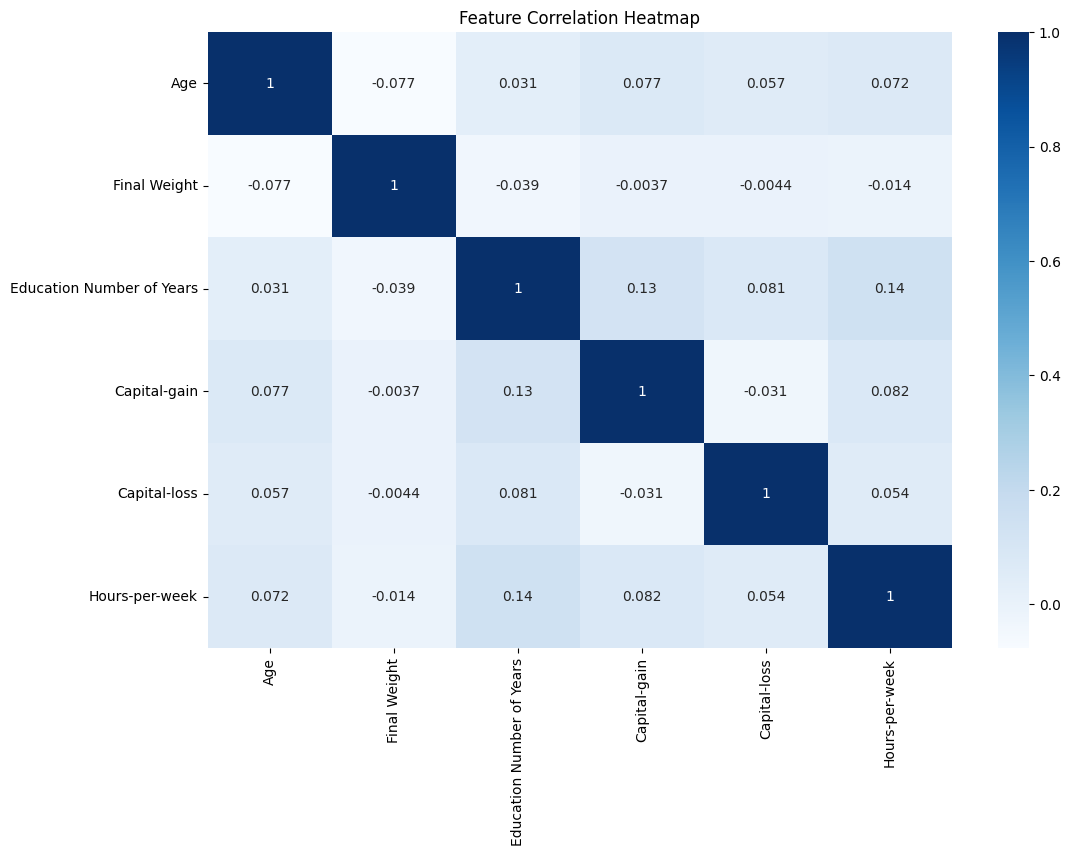

In [4]:
# Show missing values per column
print('Missing values per column:')
print(df.isnull().sum())

# Correlation heatmap (for numeric features)
numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Blues')
plt.title('Feature Correlation Heatmap')
plt.show()

# Output class distribution (bar chart)
if 'income' in df.columns:
    class_counts = df['income'].value_counts()
    plt.figure(figsize=(8, 5))
    bars = plt.bar(class_counts.index.astype(str), class_counts.values)
    plt.title('Class Distribution')
    plt.xlabel('Income Class')
    plt.ylabel('Count')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, str(height), ha='center', va='bottom')
    plt.show()

## 3. Data Preprocessing
We will address missing values, encode categorical variables, and scale features as required.
- **Missing values:** Identify and impute or drop as needed.
- **Categorical variables:** Encode using Label Encoding or One-Hot Encoding.
- **Feature scaling:** Standardize numerical features.

Each preprocessing step will be explained and justified.

In [5]:
# --- Data Preprocessing ---
# 1. Handle missing values (impute or drop as needed)
df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in [np.float64, np.int64]:
            # Impute numeric columns with median
            imputer = SimpleImputer(strategy='median')
            df_clean[col] = imputer.fit_transform(df_clean[[col]])
        else:
            # Impute categorical columns with mode
            imputer = SimpleImputer(strategy='most_frequent')
            df_clean[col] = imputer.fit_transform(df_clean[[col]])

# 2. Encode categorical variables
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'income']  # Exclude target if present
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le

# 3. Encode target variable if needed
if 'income' in df_clean.columns and df_clean['income'].dtype == 'object':
    le_target = LabelEncoder()
    df_clean['income'] = le_target.fit_transform(df_clean['income'])

# 4. Feature scaling (standardize numeric features)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'income']
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

df_clean.head()

,Age,Workclass,Final Weight,Education,Education Number of Years,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,target
0,0.025996,2.137359,-1.061979,-0.332542,1.136512,0.916138,-1.318460,-0.276685,0.392384,0.70422,0.146932,-0.217127,-0.034087,0.289462,-0.560845
1,0.828308,1.454401,-1.007104,-0.332542,1.136512,-0.410397,-0.609318,-0.900852,0.392384,0.70422,-0.144804,-0.217127,-2.213032,0.289462,-0.560845
2,-0.046942,0.088484,0.246034,0.183660,-0.419335,-1.736932,-0.136557,-0.276685,0.392384,0.70422,-0.144804,-0.217127,-0.034087,0.289462,-0.560845
3,1.047121,0.088484,0.426663,-2.397350,-1.197259,-0.410397,-0.136557,-0.900852,-1.971746,0.70422,-0.144804,-0.217127,-0.034087,0.289462,-0.560845
4,-0.776316,0.088484,1.408530,-0.332542,1.136512,-0.410397,0.808965,2.219984,-1.971746,-1.42001,-0.144804,-0.217127,-0.034087,-4.083380,-0.560845


## 4. Dataset Splitting
We will split the dataset into training and test sets (70% train, 30% test) using stratified sampling to preserve class distribution.

## 4. Dataset Splitting
We will split the preprocessed dataset into training and test sets using stratified sampling to preserve the class distribution. 70% of the data will be used for training and 30% for testing. Stratified splitting is important for classification problems to ensure that all classes are represented proportionally in both sets.

In [22]:
# --- Dataset Splitting ---
# For classification, stratified splitting is used to preserve class distribution.
# 70% train, 30% test

# Identify the target column (auto-detect or set manually if needed)
target_col = 'income' if 'income' in df_clean.columns else df_clean.columns[-1]  # fallback to last column

# Features and target
y = df_clean[target_col]
X = df_clean.drop(target_col, axis=1)

# Stratified split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
except Exception as e:
    print('Error during train/test split:', e)
    print('Check that the target column is correct and has at least 2 classes.')

# Show the shape of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34189, 14), (14653, 14), (34189,), (14653,))

## 5. Model Training & Evaluation
We will train and evaluate the following supervised learning models:
- Decision Tree
- Logistic Regression
- Neural Network (MLPClassifier)

For each model, we will report accuracy, precision, recall, F1 score, classification report, and confusion matrix.

Converted target to integer type for classification.
Decision Tree Accuracy: 0.8143042380399919
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     11147
           1       0.61      0.62      0.61      3506

    accuracy                           0.81     14653
   macro avg       0.74      0.75      0.75     14653
weighted avg       0.81      0.81      0.81     14653

Decision Tree Weighted Average Precision: 0.8147976408273512
Decision Tree Weighted Average Recall: 0.8143042380399919
Decision Tree Weighted Average F1 Score: 0.8145477980338793


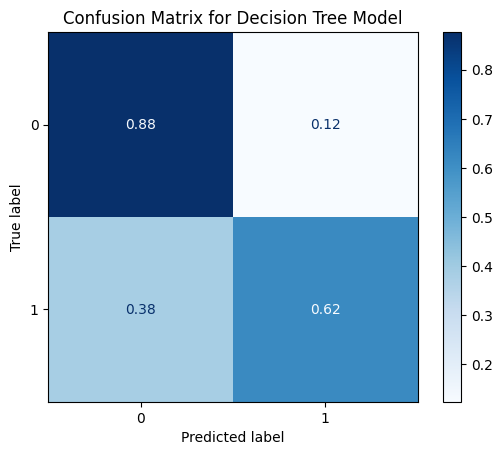

In [24]:
# --- Decision Tree Classifier ---
# Ensure target is integer/categorical for classification
if not pd.api.types.is_integer_dtype(y_train):
    # Try to convert to integer (if already encoded as float)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    print('Converted target to integer type for classification.')

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred, average='weighted', zero_division=1)
dt_recall = recall_score(y_test, dt_pred, average='weighted')
dt_f1 = f1_score(y_test, dt_pred, average='weighted')

print('Decision Tree Accuracy:', dt_accuracy)
print('Decision Tree Classification Report:\n', classification_report(y_test, dt_pred, zero_division=1))
print('Decision Tree Weighted Average Precision:', dt_precision)
print('Decision Tree Weighted Average Recall:', dt_recall)
print('Decision Tree Weighted Average F1 Score:', dt_f1)

cm = confusion_matrix(y_test, dt_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

Naive Bayes Accuracy: 0.8020200641506858
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88     11147
           1       0.67      0.33      0.45      3506

    accuracy                           0.80     14653
   macro avg       0.75      0.64      0.66     14653
weighted avg       0.78      0.80      0.78     14653

Naive Bayes Weighted Average Precision: 0.7845068505574806
Naive Bayes Weighted Average Recall: 0.8020200641506858
Naive Bayes Weighted Average F1 Score: 0.7758979088695148


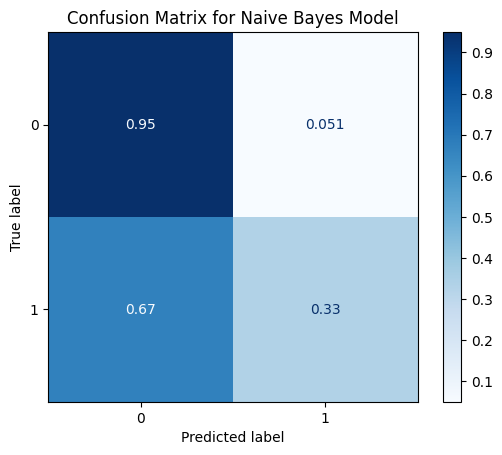

In [25]:
# --- Naive Bayes ---
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred, average='weighted', zero_division=1)
nb_recall = recall_score(y_test, nb_pred, average='weighted')
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

print('Naive Bayes Accuracy:', nb_accuracy)
print('Naive Bayes Classification Report:\n', classification_report(y_test, nb_pred, zero_division=1))
print('Naive Bayes Weighted Average Precision:', nb_precision)
print('Naive Bayes Weighted Average Recall:', nb_recall)
print('Naive Bayes Weighted Average F1 Score:', nb_f1)

cm = confusion_matrix(y_test, nb_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

Neural Network Accuracy: 0.8505425510134443
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     11147
           1       0.70      0.65      0.67      3506

    accuracy                           0.85     14653
   macro avg       0.80      0.78      0.79     14653
weighted avg       0.85      0.85      0.85     14653

Neural Network Weighted Average Precision: 0.8469290757474479
Neural Network Weighted Average Recall: 0.8505425510134443
Neural Network Weighted Average F1 Score: 0.8483447201444761


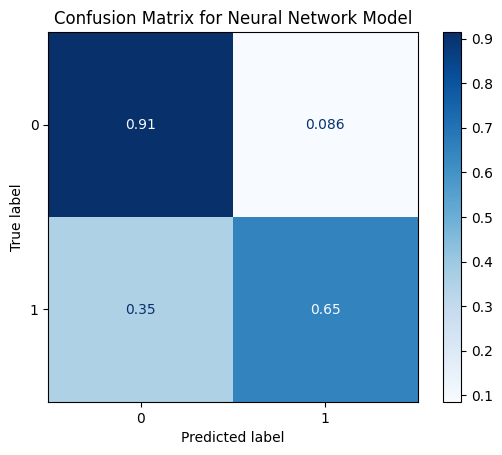

In [26]:
# --- Neural Network (MLPClassifier) ---
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred, average='weighted', zero_division=1)
mlp_recall = recall_score(y_test, mlp_pred, average='weighted')
mlp_f1 = f1_score(y_test, mlp_pred, average='weighted')

print('Neural Network Accuracy:', mlp_accuracy)
print('Neural Network Classification Report:\n', classification_report(y_test, mlp_pred, zero_division=1))
print('Neural Network Weighted Average Precision:', mlp_precision)
print('Neural Network Weighted Average Recall:', mlp_recall)
print('Neural Network Weighted Average F1 Score:', mlp_f1)

cm = confusion_matrix(y_test, mlp_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Neural Network Model')
plt.show()

## 6. Model Comparison & Visualization
We will compare the performance of Decision Tree, Logistic Regression, and Neural Network models using bar charts for accuracy, precision, recall, and F1 score. Confusion matrices for each model have already been shown above.

In [ ]:
# --- Logistic Regression ---
# Ensure target is integer/categorical for classification
if not pd.api.types.is_integer_dtype(y_train):
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    print('Converted target to integer type for classification.')

lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='weighted', zero_division=1)
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print('Logistic Regression Accuracy:', lr_accuracy)
print('Logistic Regression Classification Report:\n', classification_report(y_test, lr_pred, zero_division=1))
print('Logistic Regression Weighted Average Precision:', lr_precision)
print('Logistic Regression Weighted Average Recall:', lr_recall)
print('Logistic Regression Weighted Average F1 Score:', lr_f1)

cm = confusion_matrix(y_test, lr_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

# --- Model Comparison & Visualization ---
models = ['Decision Tree', 'Logistic Regression', 'Neural Network']
accuracy_scores = [dt_accuracy, lr_accuracy, mlp_accuracy]
precision_scores = [dt_precision, lr_precision, mlp_precision]
recall_scores = [dt_recall, lr_recall, mlp_recall]
f1_scores = [dt_f1, lr_f1, mlp_f1]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision_scores, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

NameError: name 'lr_accuracy' is not defined

## 7. Unsupervised Learning: KMeans Clustering
We will apply KMeans clustering to the dataset (excluding the target variable) and visualize the resulting clusters.

In [ ]:
# --- KMeans Clustering ---
# Exclude the target variable for clustering
X_cluster = df_clean.drop('income', axis=1)

# Apply KMeans with 2 clusters (as there are 2 income classes)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

# Add cluster labels to the dataframe
df_clean['Cluster'] = clusters

# Visualize clusters using the first two principal components (optional, for better visualization)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('KMeans Clusters (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 8. Conclusion
Summarize the findings, compare model performances, discuss challenges faced, and provide insights based on the results.